In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [4]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

# Delete Image Null

In [5]:
print(merged_df.shape)

merged_df = merged_df.dropna(subset=['pca_result'])

print(merged_df.shape)

(481, 67)
(473, 67)


In [6]:
''' 
feature_selection = "all_features"
#feature_selection = "selected_features"

features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023",
    # "longitude_sin", 
    # "longitude_cos", 
    # "latitude_sin", 
    # "latitude_cos",  
    "population_density",

    # Image data

    "pca_result", 
    # "K_mean_label", 
    # "C_mean_label", 
    # "GMM_label", 
    "Cluster_1",
    "Cluster_2", 
    "Cluster_3",
    "Cluster_4", 
    "Cluster_5",
    "Cluster_6", 
    "Cluster_7", 
    "Cluster_8", 
    "Cluster_9", 
    "Cluster_10",
    "Cluster_11", 
    "Cluster_12", 
    "Cluster_13", 
    "Cluster_14", 
    "Cluster_15",
    "Cluster_16", 
    "Cluster_17", 
    "Cluster_18", 
    "Cluster_19"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU", 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    "total_precipitation_2023": "Precip",
    # "longitude_sin": "Long_Sin", 
    # "longitude_cos": "Long_Cos", 
    # "latitude_sin": "Lat_Sin", 
    # "latitude_cos": "Lat_Cos",  
    "population_density": "Pop_Dens",
    "pca_result": "PCA",
    "Cluster_1": "C1",
    "Cluster_2": "C2",
    "Cluster_3": "C3",
    "Cluster_4": "C4",
    "Cluster_5": "C5",
    "Cluster_6": "C6",
    "Cluster_7": "C7",
    "Cluster_8": "C8",
    "Cluster_9": "C9",
    "Cluster_10": "C10",
    "Cluster_11": "C11",
    "Cluster_12": "C12",
    "Cluster_13": "C13",
    "Cluster_14": "C14",
    "Cluster_15": "C15",
    "Cluster_16": "C16",
    "Cluster_17": "C17",
    "Cluster_18": "C18",
    "Cluster_19": "C19"
}


target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']
''' 



' \nfeature_selection = "all_features"\n#feature_selection = "selected_features"\n\nfeatures = [\n    "hdd_total_year", \n    "cdd_total_year", \n    "GDP_per_capita", \n    "Urbanization_Rate_2022",\n    "latitude",\n    "longitude",  \n    "Paris_Agreement",\n    "Subnational HDI", \n    "Educational index", \n    "Income index",\n    "2m_temperature_2023_avg",\n    "2m_dewpoint_temperature_2023_avg",\n    "total_precipitation_2023",\n    # "longitude_sin", \n    # "longitude_cos", \n    # "latitude_sin", \n    # "latitude_cos",  \n    "population_density",\n\n    # Image data\n\n    "pca_result", \n    # "K_mean_label", \n    # "C_mean_label", \n    # "GMM_label", \n    "Cluster_1",\n    "Cluster_2", \n    "Cluster_3",\n    "Cluster_4", \n    "Cluster_5",\n    "Cluster_6", \n    "Cluster_7", \n    "Cluster_8", \n    "Cluster_9", \n    "Cluster_10",\n    "Cluster_11", \n    "Cluster_12", \n    "Cluster_13", \n    "Cluster_14", \n    "Cluster_15",\n    "Cluster_16", \n    "Cluster_17"

In [7]:
#feature_selection = "all_features"
feature_selection = "selected_features"

features = [
    "hdd_total_year", 
    "cdd_total_year", 
    # "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    # "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023",
    # "longitude_sin", 
    # "longitude_cos", 
    # "latitude_sin", 
    # "latitude_cos",  
    # "population_density",

    # Image data

    # "pca_result", 
    # "K_mean_label", 
    # "C_mean_label", 
    # "GMM_label", 
    # "Cluster_1",
    # "Cluster_2", 
    # "Cluster_3",
    # "Cluster_4", 
    # "Cluster_5",
    # "Cluster_6", 
    # "Cluster_7", 
    # "Cluster_8", 
    # "Cluster_9", 
    # "Cluster_10",
    # "Cluster_11", 
    # "Cluster_12", 
    # "Cluster_13", 
    # "Cluster_14", 
    # "Cluster_15",
    # "Cluster_16", 
    # "Cluster_17", 
    # "Cluster_18", 
    # "Cluster_19"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    #"GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    #"Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU", 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    "total_precipitation_2023": "Precip",
    # "longitude_sin": "Long_Sin", 
    # "longitude_cos": "Long_Cos", 
    # "latitude_sin": "Lat_Sin", 
    # "latitude_cos": "Lat_Cos",  
    "population_density": "Pop_Dens",
    # "pca_result": "PCA",
    # "Cluster_1": "C1",
    # "Cluster_2": "C2",
    # "Cluster_3": "C3",
    # "Cluster_4": "C4",
    # "Cluster_5": "C5",
    # "Cluster_6": "C6",
    # "Cluster_7": "C7",
    # "Cluster_8": "C8",
    # "Cluster_9": "C9",
    # "Cluster_10": "C10",
    # "Cluster_11": "C11",
    # "Cluster_12": "C12",
    # "Cluster_13": "C13",
    # "Cluster_14": "C14",
    # "Cluster_15": "C15",
    # "Cluster_16": "C16",
    # "Cluster_17": "C17",
    # "Cluster_18": "C18",
    # "Cluster_19": "C19"
}


target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']




# CatBoost

In [8]:
# CatBoost parameters
cat_params = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'verbose': False,
    'random_seed': 42,
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 20,
    'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'l2_leaf_reg': 3,
    'bootstrap_type': 'Bernoulli'
}

### CatBoost - Within Domain

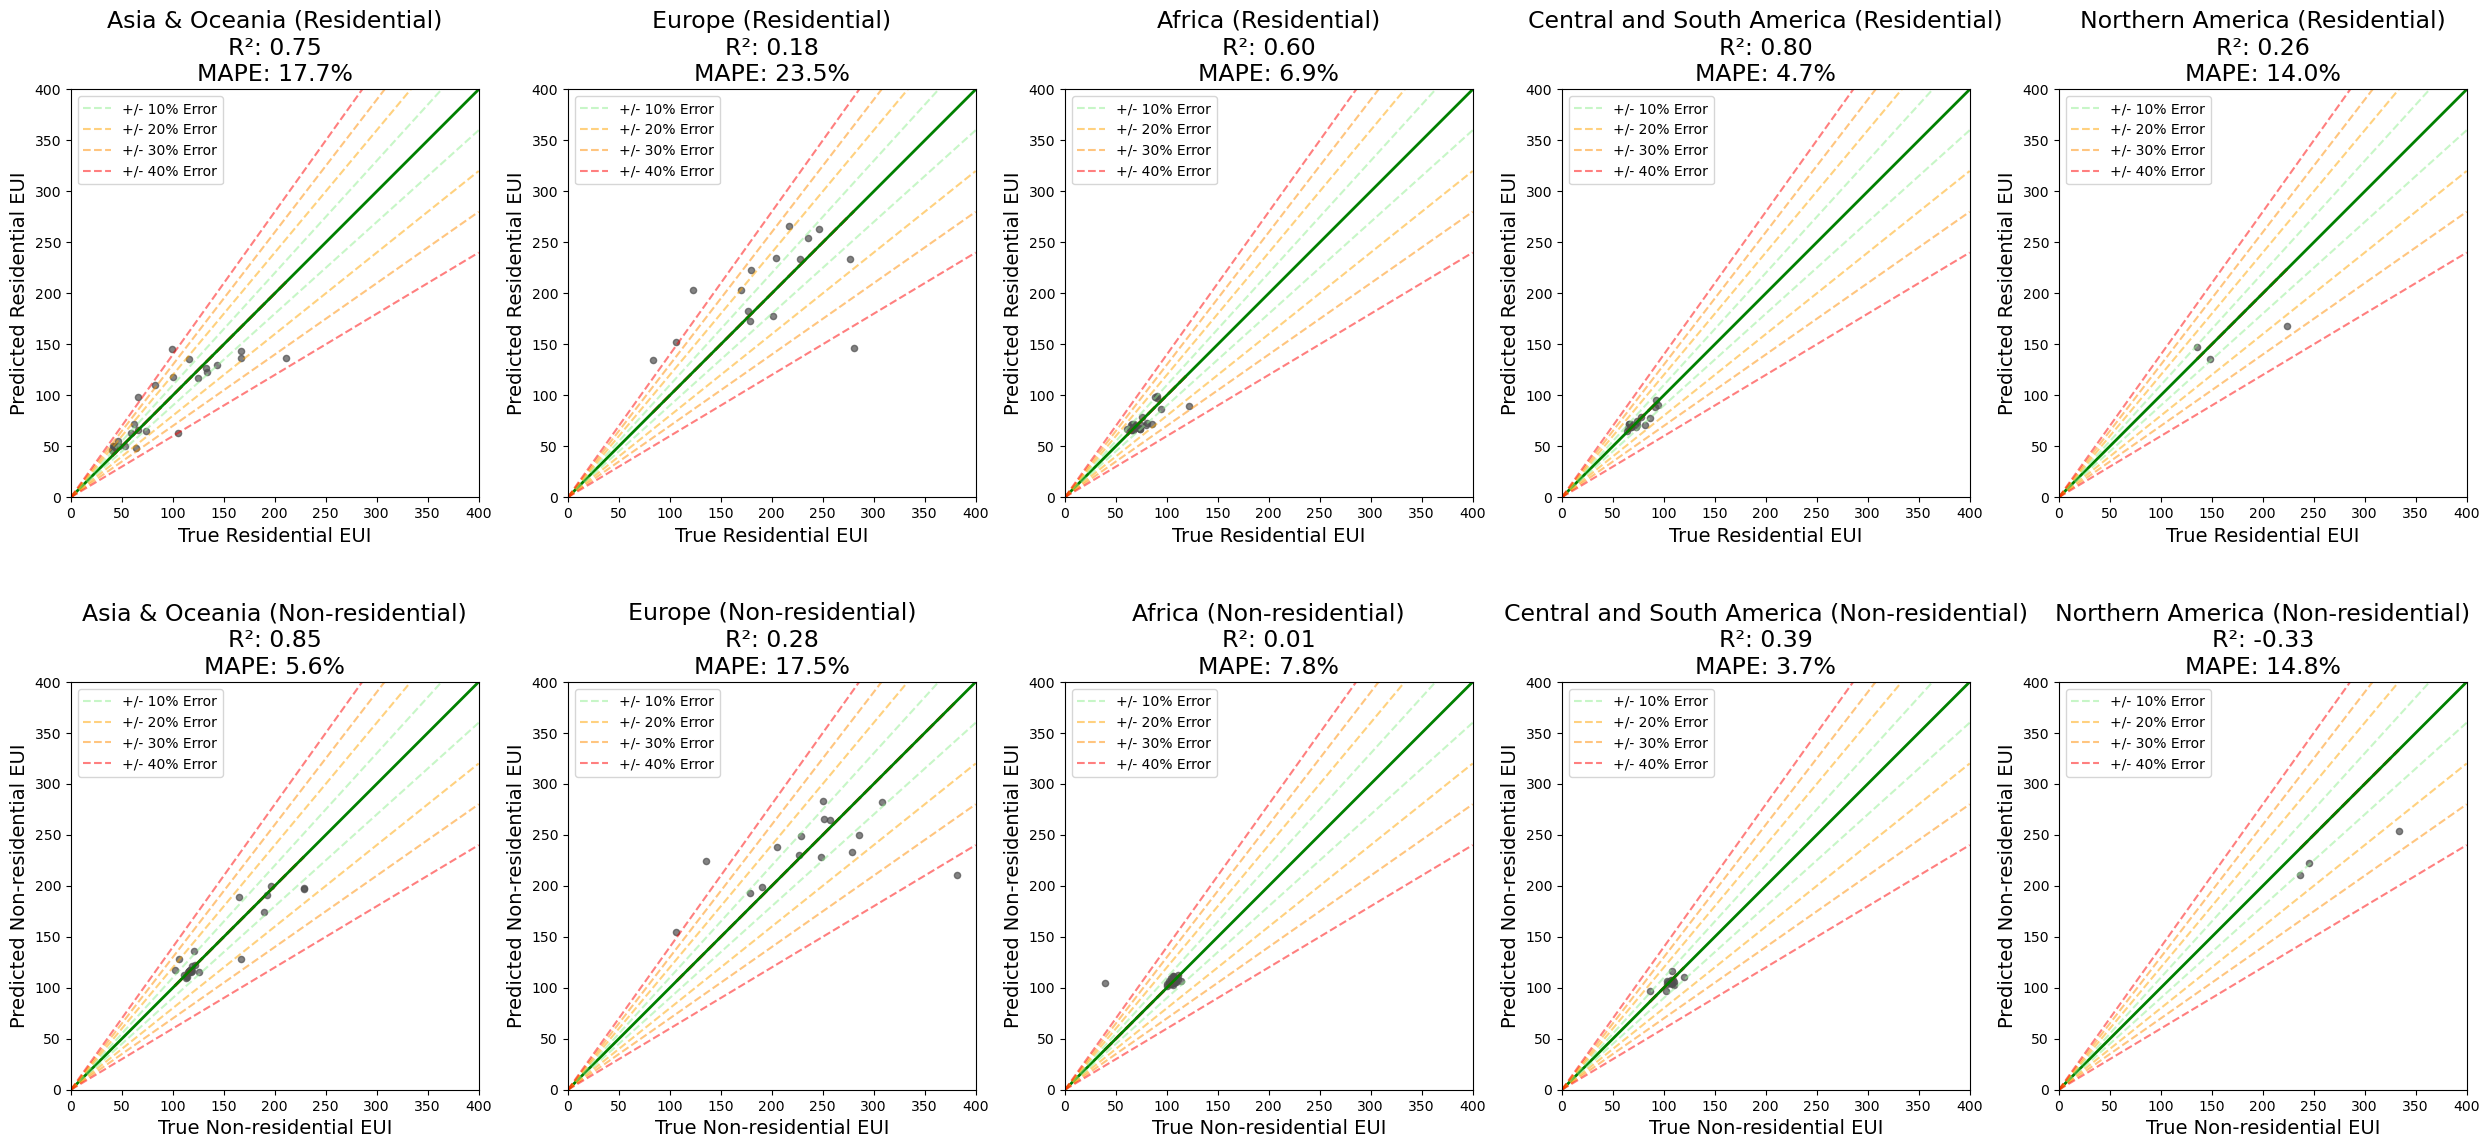

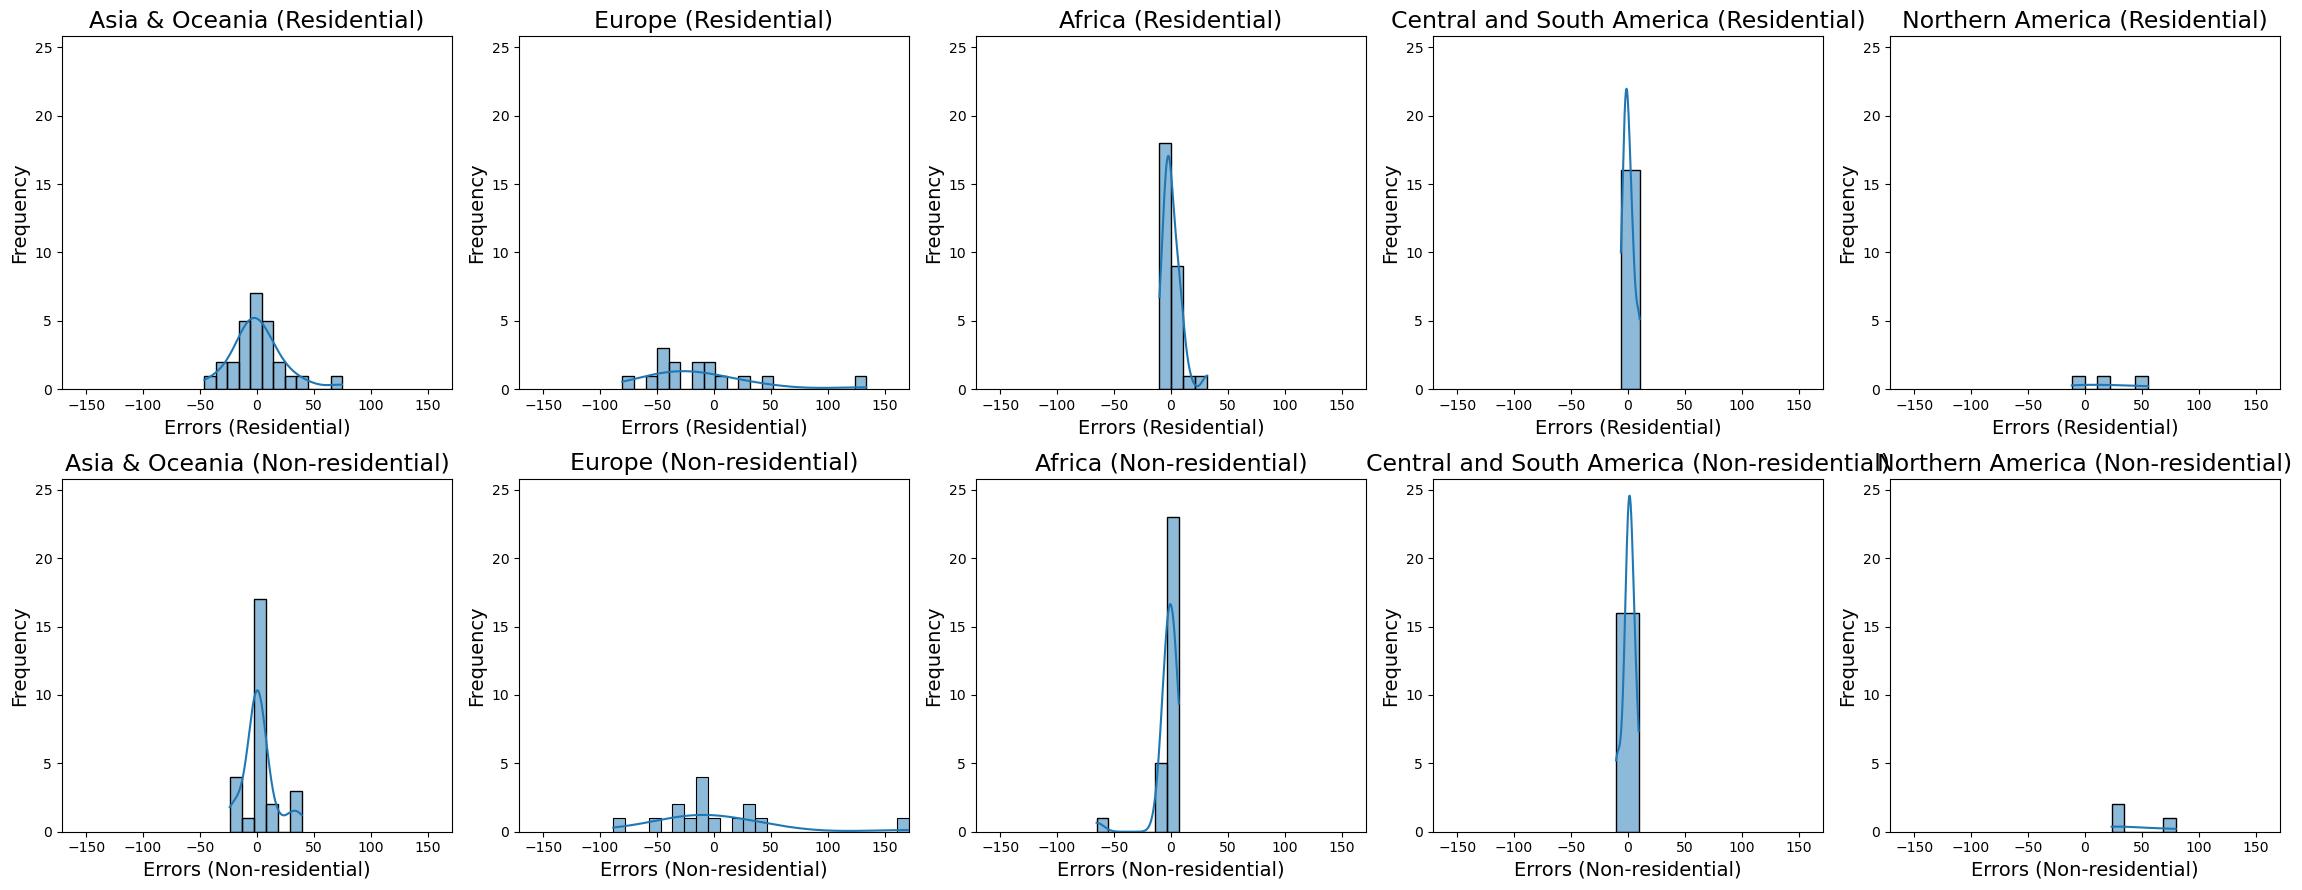

In [9]:
# Within Domain
model_cat_within = CatBoostRegressor(**cat_params)
results_cat_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_cat_within, 
    save_path=f'../figures/model_plots/{feature_selection}/cat_within_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_within,
    save_path=f'../figures/model_plots/{feature_selection}/cat_within_domain_error_distribution.png')


### CatBoost - Cross Domain

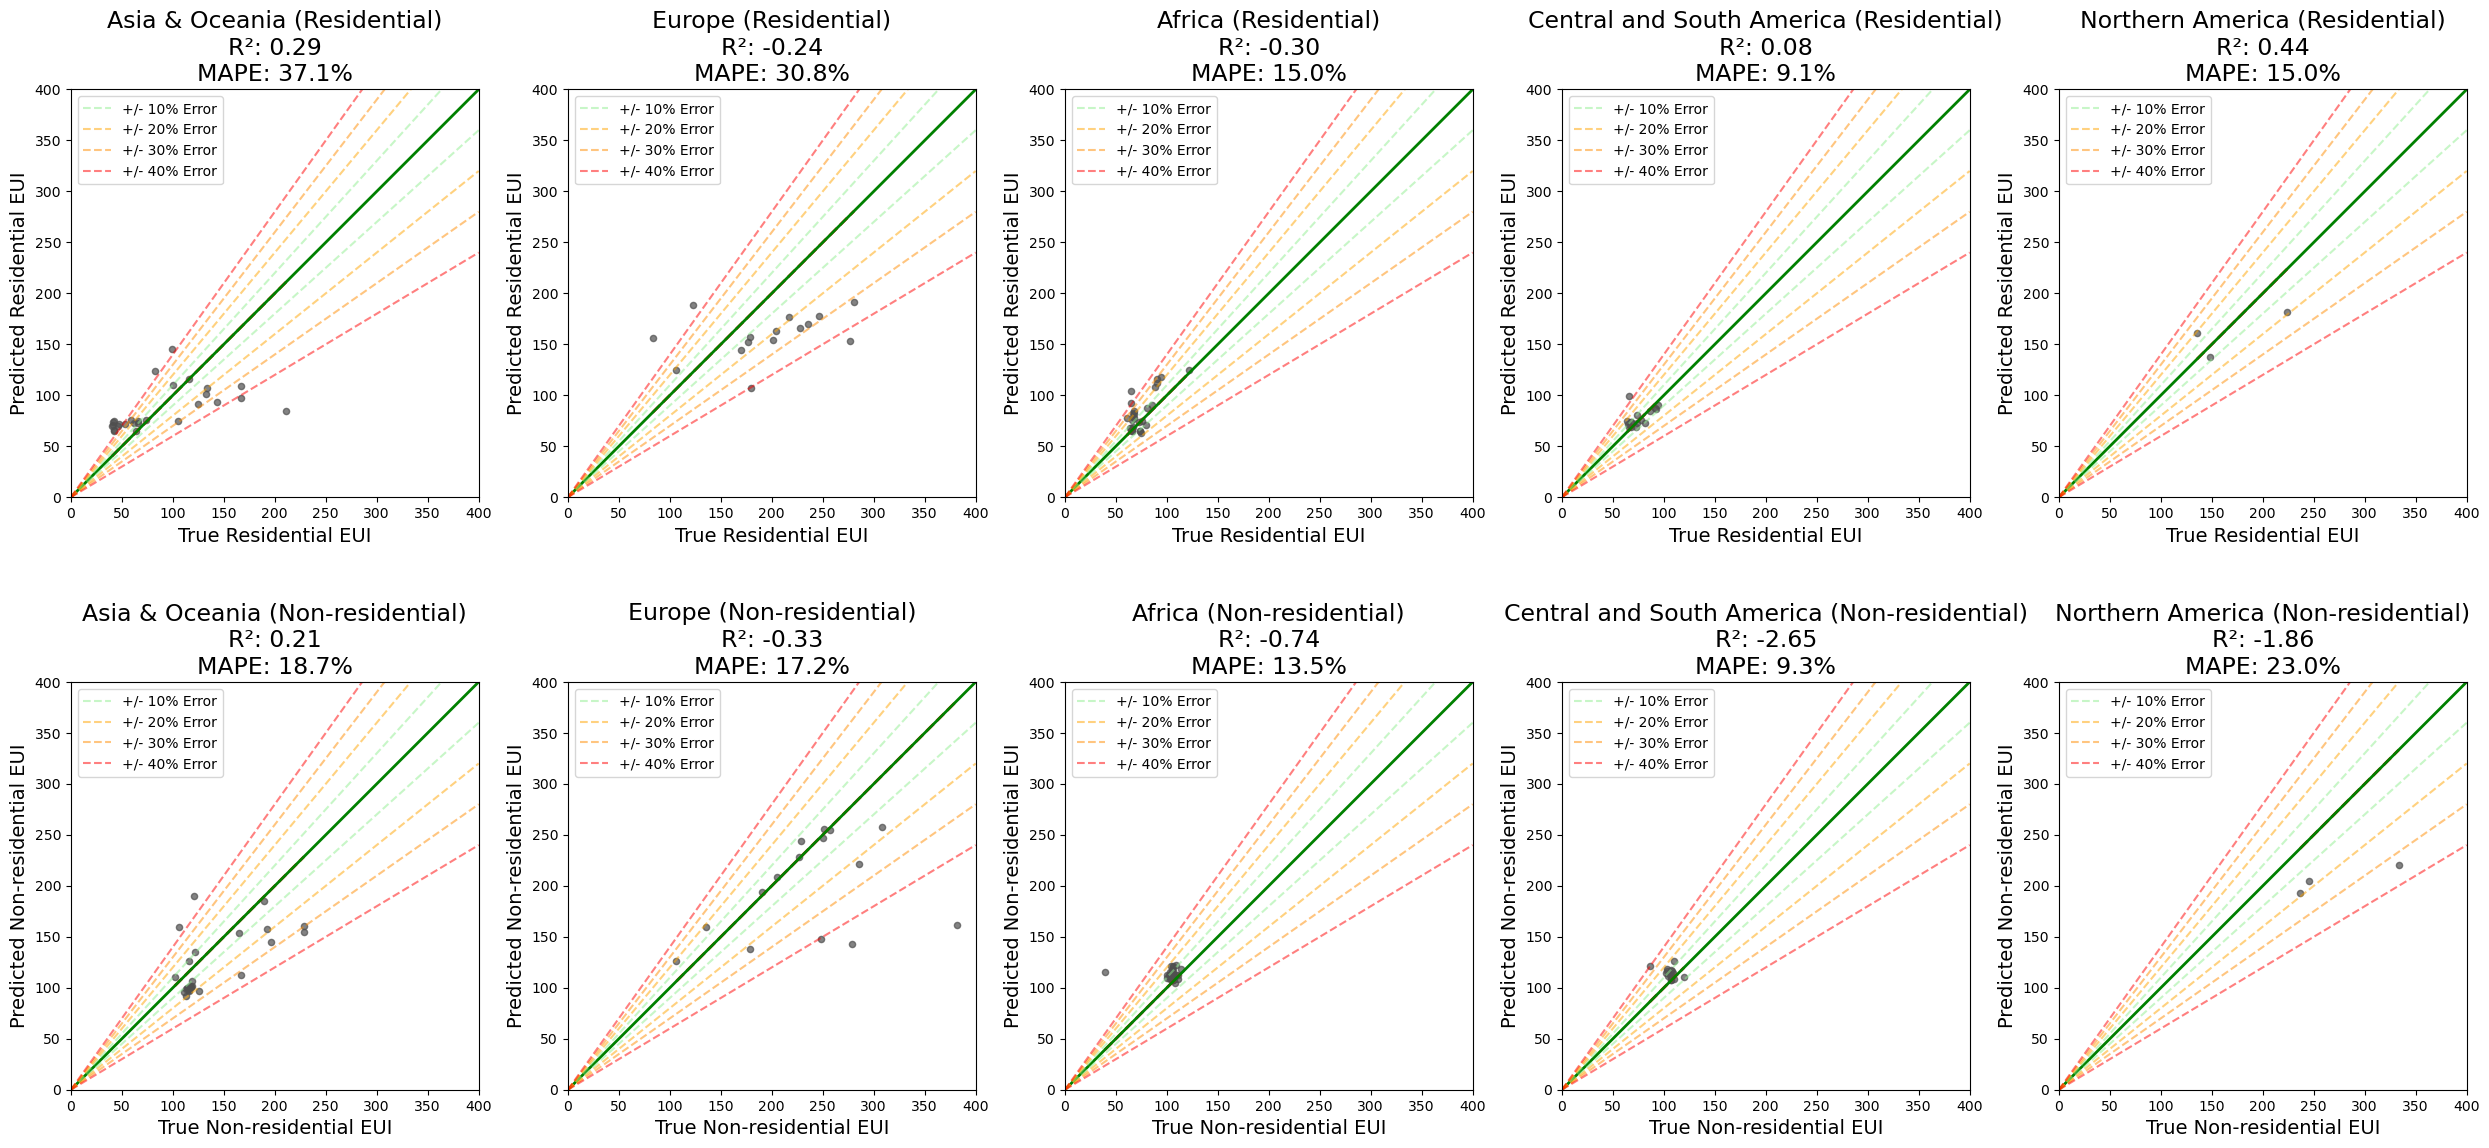

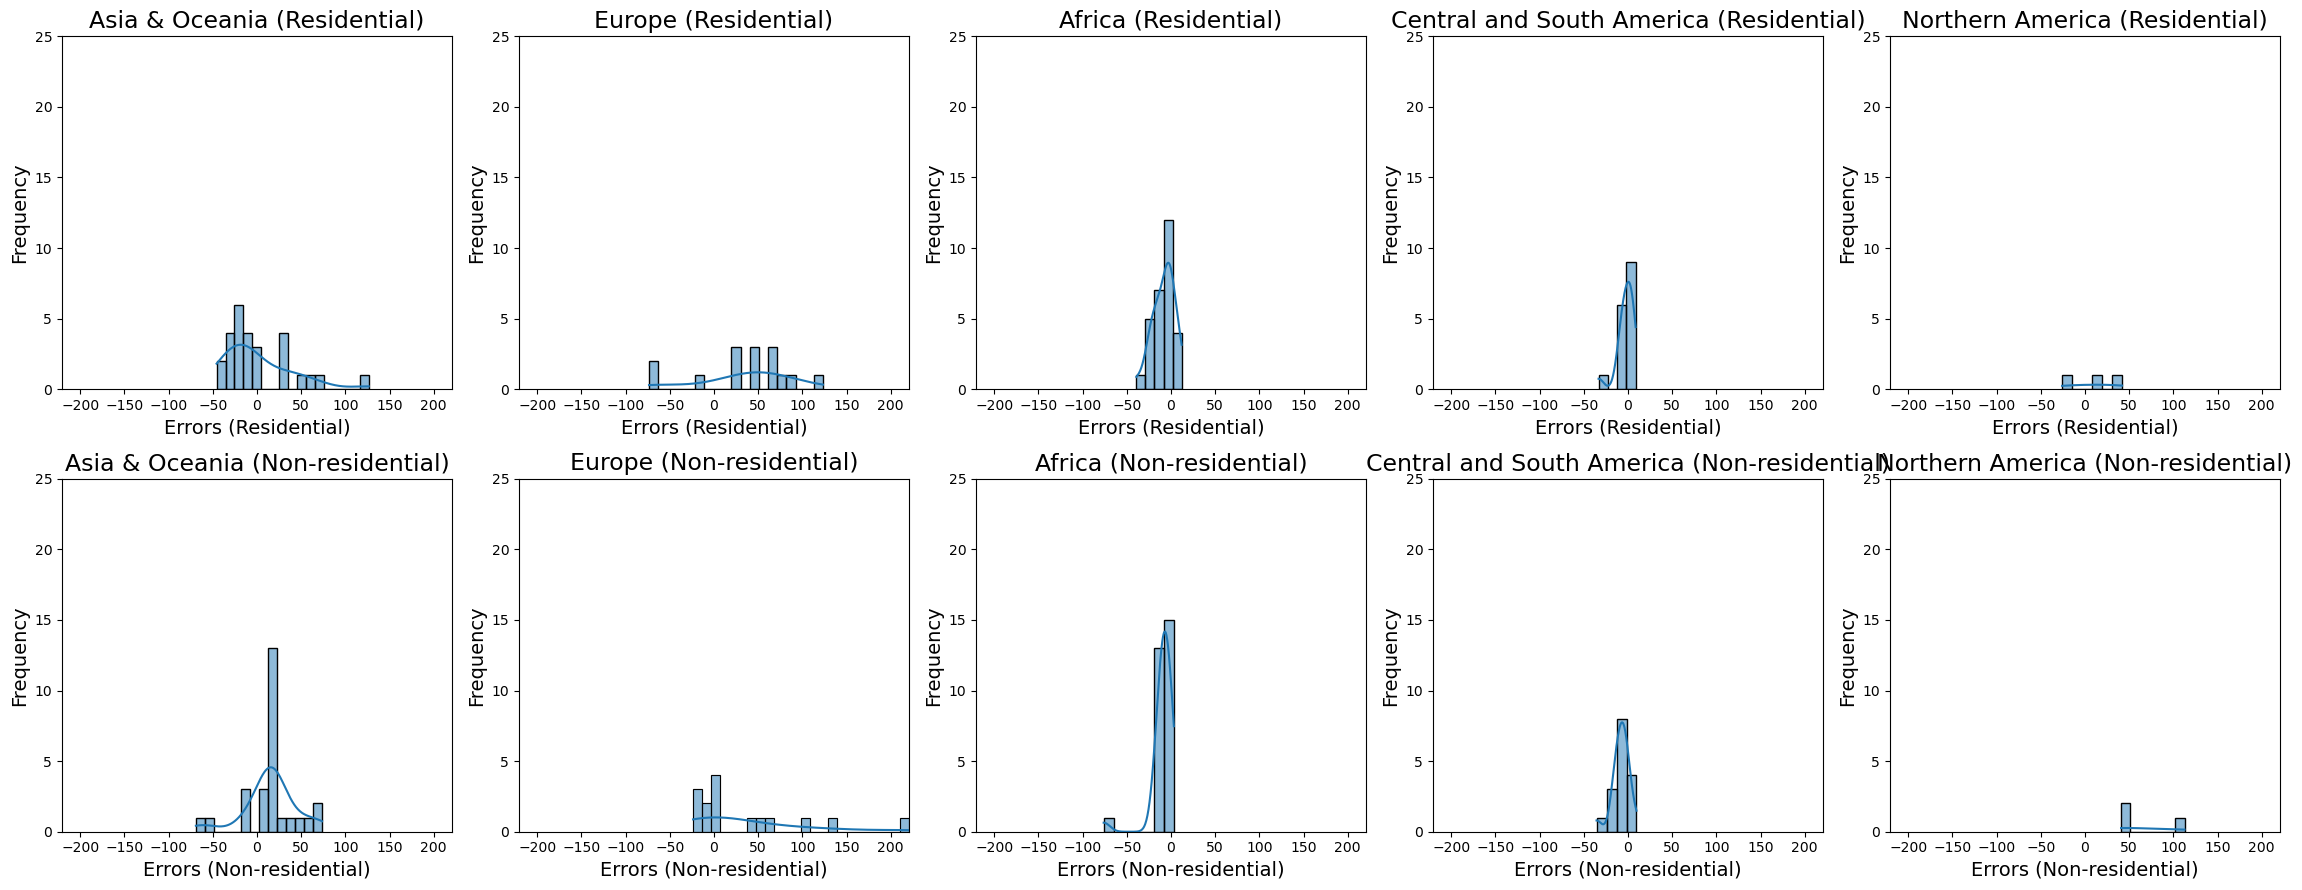

In [10]:
# Cross-domain
model_cat_cross = CatBoostRegressor(**cat_params)
results_cat_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_cat_cross,
    save_path=f'../figures/model_plots/{feature_selection}/cat_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_cross,
    save_path=f'../figures/model_plots/{feature_selection}/cat_cross_domain_error_distribution.png')


### CatBoost - All Domain

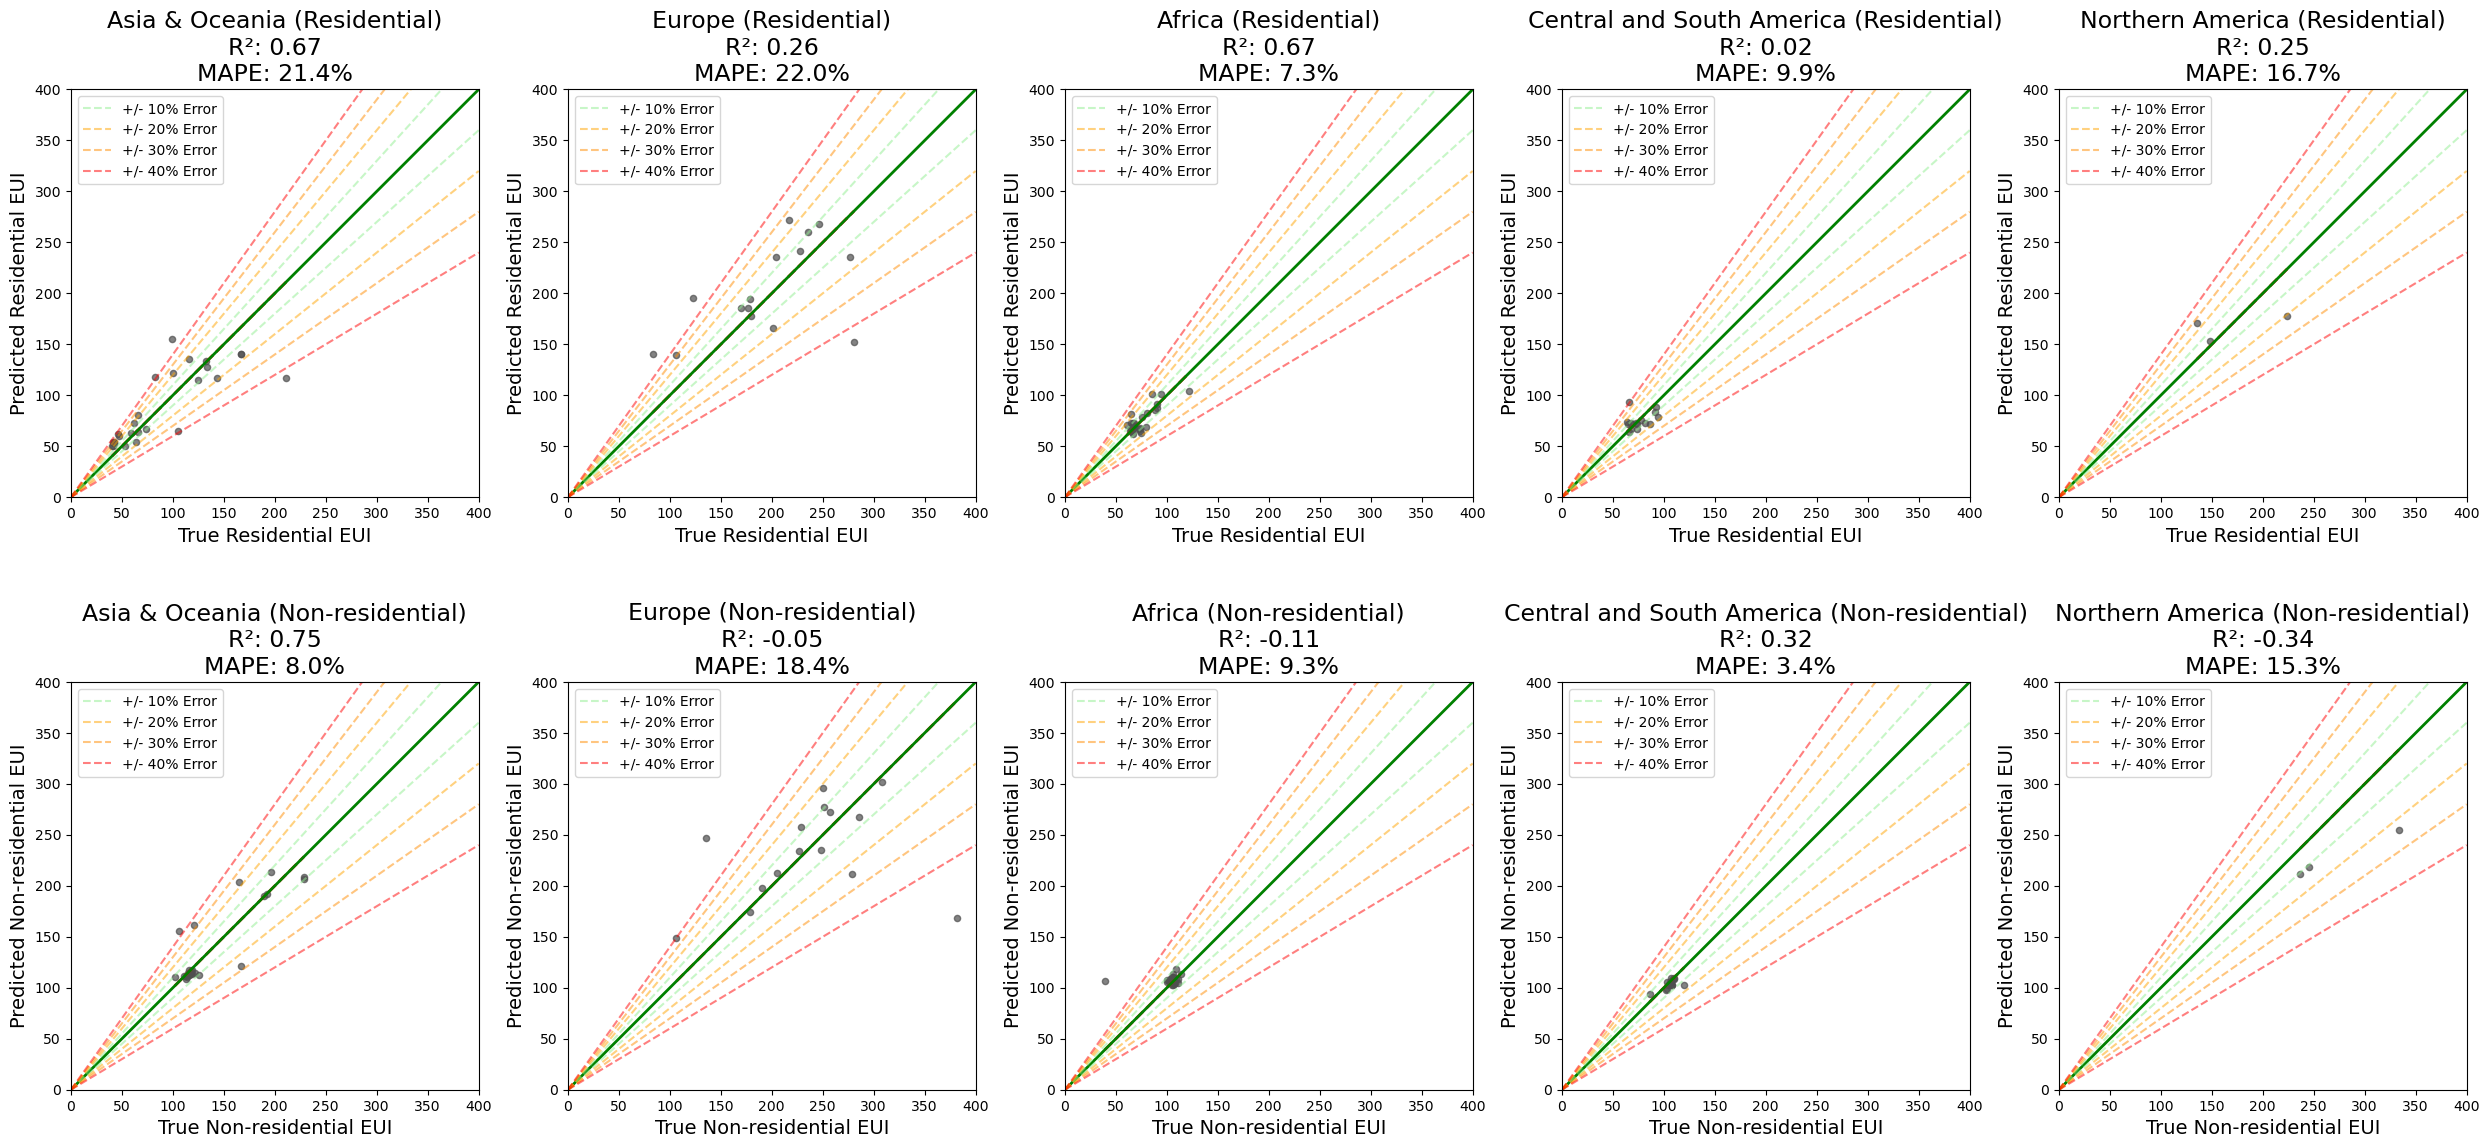

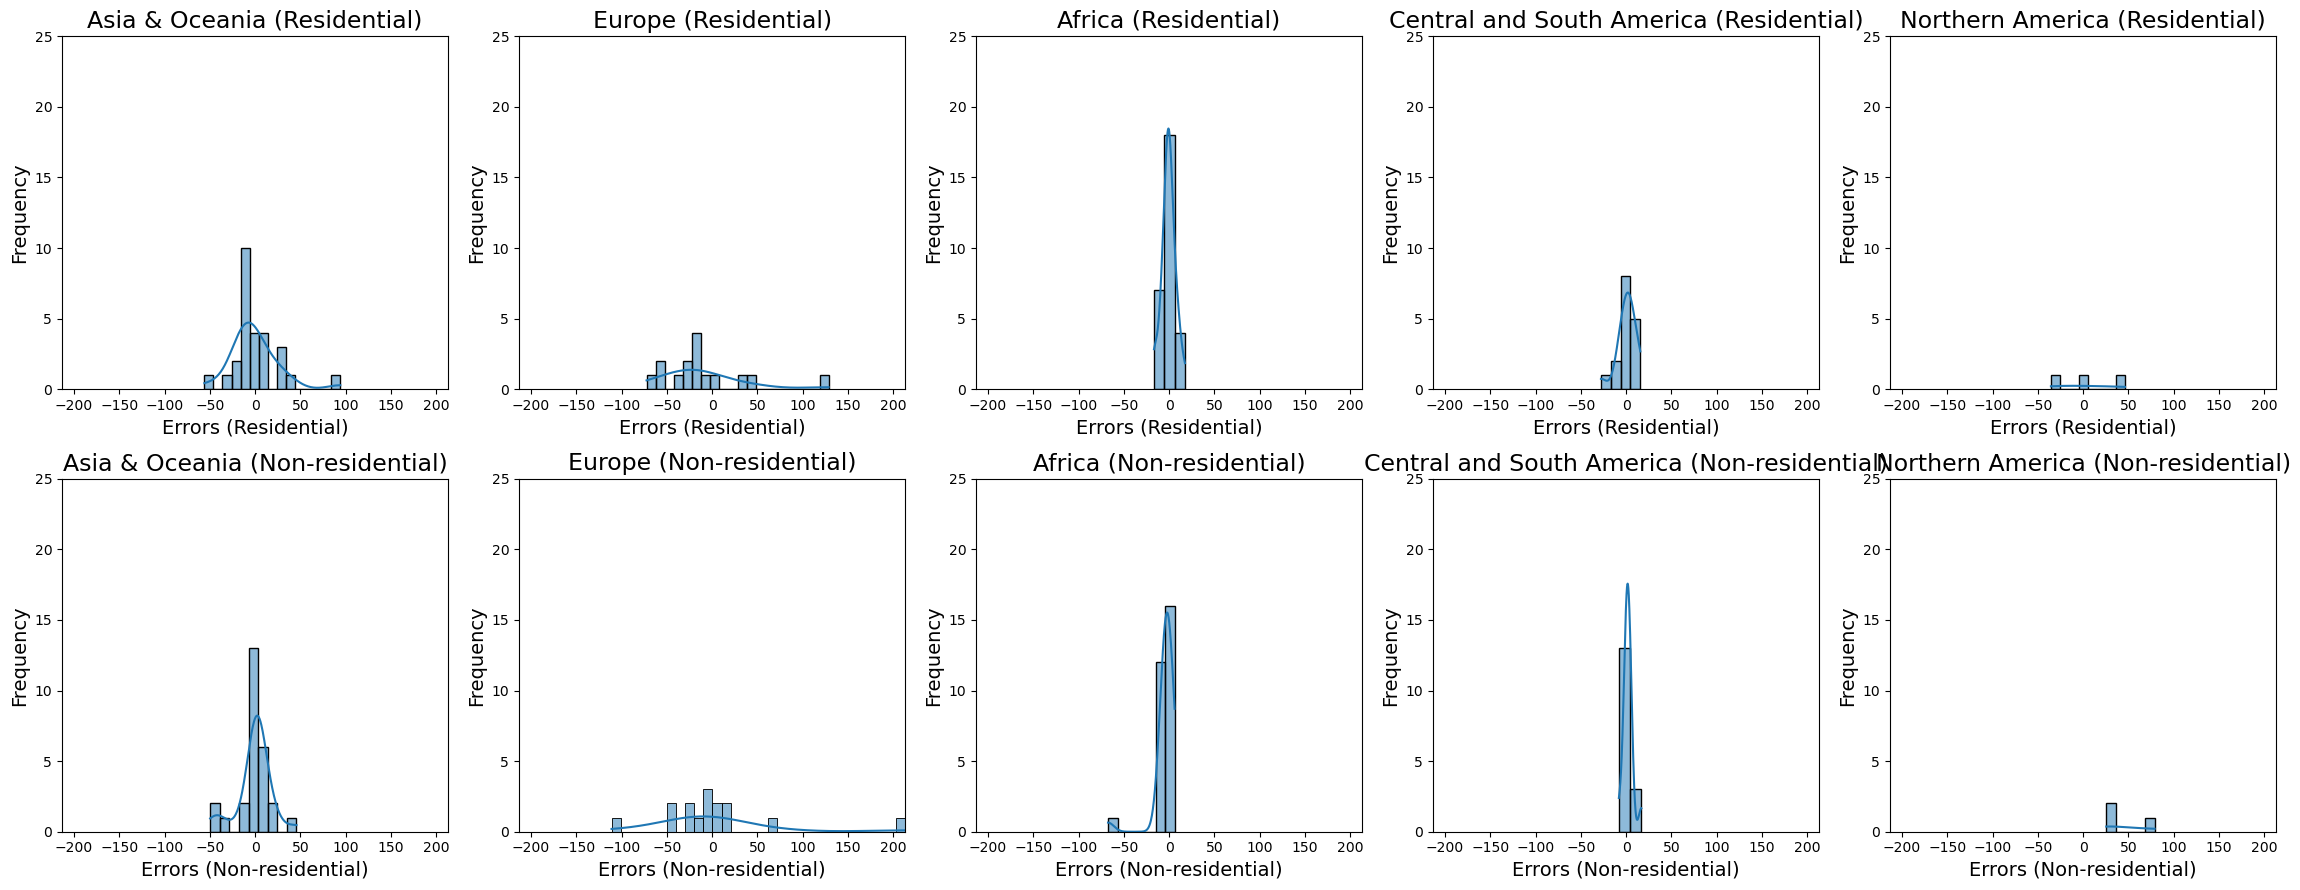

In [11]:
# All-domain
model_cat_all = CatBoostRegressor(**cat_params)
results_cat_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_cat_all,
    save_path=f'../figures/model_plots/{feature_selection}/cat_all_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_all,
    save_path=f'../figures/model_plots/{feature_selection}/cat_all_domain_error_distribution.png')


In [12]:
CatModel = lambda: CatBoostRegressor(**cat_params)

cat_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=CatModel,   
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in cat_params.items())
)

cat_detailed_results['Model'] = 'CatBoostRegressor'

cat_average_results = calculate_average_metrics(cat_detailed_results).reset_index()
cat_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, Urbanization_R...",HDD | CDD | URB | Lat | Long | HDI | EDU | Inc...,9.88,0.240,1209.855,27.620,19.600,9.24
1,Non-residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, Urbanization_R...",HDD | CDD | URB | Lat | Long | HDI | EDU | Inc...,16.34,-1.073,2548.649,42.394,31.430,16.26
2,Non-residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, Urbanization_R...",HDD | CDD | URB | Lat | Long | HDI | EDU | Inc...,10.88,0.113,1535.936,31.070,21.146,10.16
3,Residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, Urbanization_R...",HDD | CDD | URB | Lat | Long | HDI | EDU | Inc...,13.36,0.518,865.281,24.055,18.297,13.42
4,Residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, Urbanization_R...",HDD | CDD | URB | Lat | Long | HDI | EDU | Inc...,21.40,0.055,1319.027,31.048,25.897,20.38
5,Residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, Urbanization_R...",HDD | CDD | URB | Lat | Long | HDI | EDU | Inc...,15.46,0.372,871.926,25.313,19.570,15.02


In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
cat_detailed_results.to_csv(f'../results/{feature_selection}/{timestamp}_cat_detailed_results.csv')
cat_average_results.to_csv(f'../results/{feature_selection}/{timestamp}_cat_average_results.csv')

# 